In [1]:
import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.get_device_capability()[0] >= 8:
    torch.set_float32_matmul_precision('high')

In [3]:
class LitMLPModel(L.LightningModule):
    def __init__(
        self,
        layer_dims = [2, 100, 1],
        lr=1e-3,
    ):
        super().__init__()
        args = vars()
        for param in list(signature(LitMLPModel.__init__).parameters)[1:]:
            setattr(self, param, args[param])
        modules = []
        for (a, b) in zip(layer_dims[:-1], layer_dims[1:]):
            modules.append(nn.Linear(a, b))
            #modules.append(nn.GELU())
            modules.append(nn.ReLU())
        modules.pop() # discard last relu
        self.module_list = nn.ModuleList(modules)
        self.save_hyperparameters()

    def forward(self, batch):
        x = batch['x']
        for module in self.module_list:
            x = module(x)
        return x

    def loss(self, batch):
        y_hat = self.forward(batch)
        return torch.mean((y_hat.flatten() - batch['y'].flatten()) ** 2)

    def training_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('train_loss', loss.item(), on_step=True)
        self.log('global_step', self.trainer.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('val_loss', loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('test_loss', loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(
            params=self.module_list.parameters(),
            lr=self.lr,
        )
        # scheduler = transformers.get_cosine_schedule_with_warmup(
        #     optimizer=optimizer,
        #     num_warmup_steps=self.num_warmup_steps,
        #     num_training_steps=9200 #1 epoch #self.trainer.estimated_stepping_batches,
        # )
        #print('NUM TRAINING STEPS', self.trainer.estimated_stepping_batches)
        # HF's schedulers are on 'step' interval (I think)
        return optimizer
        #(
            #[optimizer],
            # [{"scheduler": scheduler, "interval": "step"}]
        #)

In [4]:
def f(x, a=10):
    return torch.sin(a*x)
    #return x - np.floor(a * x) * (1 + (-1) ** (1 + np.floor(a * x))) / a

In [5]:
class SyntheticPointDataset(Dataset):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, value):
        a = 10
        b = 5 * np.sqrt(5)
        y = torch.normal(0, 1, (1,))
        x = torch.stack(
            [
                (1 + 0.3 * torch.cos(b * y)) * torch.cos(a * y),
                (1 + 0.3 * torch.cos(b * y)) * torch.sin(a * y),
                0.3 * torch.sin(b * y)
            ],
            dim=0
        ).flatten()
        return {'x': x, 'y': y}

In [6]:
train = DataLoader(SyntheticPointDataset(size=1000000), batch_size=512, )#num_workers=95)
val = DataLoader(SyntheticPointDataset(size=10000), batch_size=512, )#num_workers=95)

In [7]:
NAME = 'SYNTH-MLP-TORUS'
PROJ = 'LAISR_FUTURE_SYNTHETIC'
wandb.login(key='os.environ[WANDB_API_KEY]', relogin=True)
wandb_logger = WandbLogger(
    name=NAME,
    project=PROJ,
    log_model=False,   # Only save checkpoints locally
)
lr_monitor = LearningRateMonitor()
checkpoint_callback = ModelCheckpoint(
    dirpath="/home/wwu/checkpoints",
    filename=NAME + "_{global_step}_{val_loss:.2f}",
    every_n_epochs=10,
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    divergence_threshold=15,
    min_delta=0.00,
    patience=100000,
    verbose=False,
    mode='min',
)
trainer = L.Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    # infinite data -- no need for val
    check_val_every_n_epoch=10000,
    #val_check_interval=1.0,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    max_epochs=100,
    enable_progress_bar=True,
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/wwu/.netrc
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
model = LitMLPModel(
    lr=5e-3,
    layer_dims=[3, 512, 512, 1],
)
wandb_logger.watch(model.module_list, log='all')

wandb: Currently logged in as: wilswu. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [9]:
model.to('cuda')

LitMLPModel(
  (module_list): ModuleList(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [10]:
trainer.fit(
    model=model,
    train_dataloaders=train,
    val_dataloaders=val,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | module_list | ModuleList | 265 K 
-------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.061     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.
/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [13]:
model.to('cuda')

LitMLPModel(
  (module_list): ModuleList(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [31]:
x.shape

torch.Size([600, 3, 1])

In [42]:
a = 10
b = 5 * np.sqrt(5)
y = torch.arange(-1, 1, 0.001, device='cuda').reshape((-1, 1))
x = torch.stack(
    [
        (1 + 0.3 * torch.cos(b * y)) * torch.cos(a * y),
        (1 + 0.3 * torch.cos(b * y)) * torch.sin(a * y),
        0.3 * torch.sin(b * y)
    ],
    dim=1
).squeeze(-1)
yhat = model({'x': x})
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()
yhat = yhat.cpu().detach().numpy()

In [43]:
y.shape

(2000, 1)

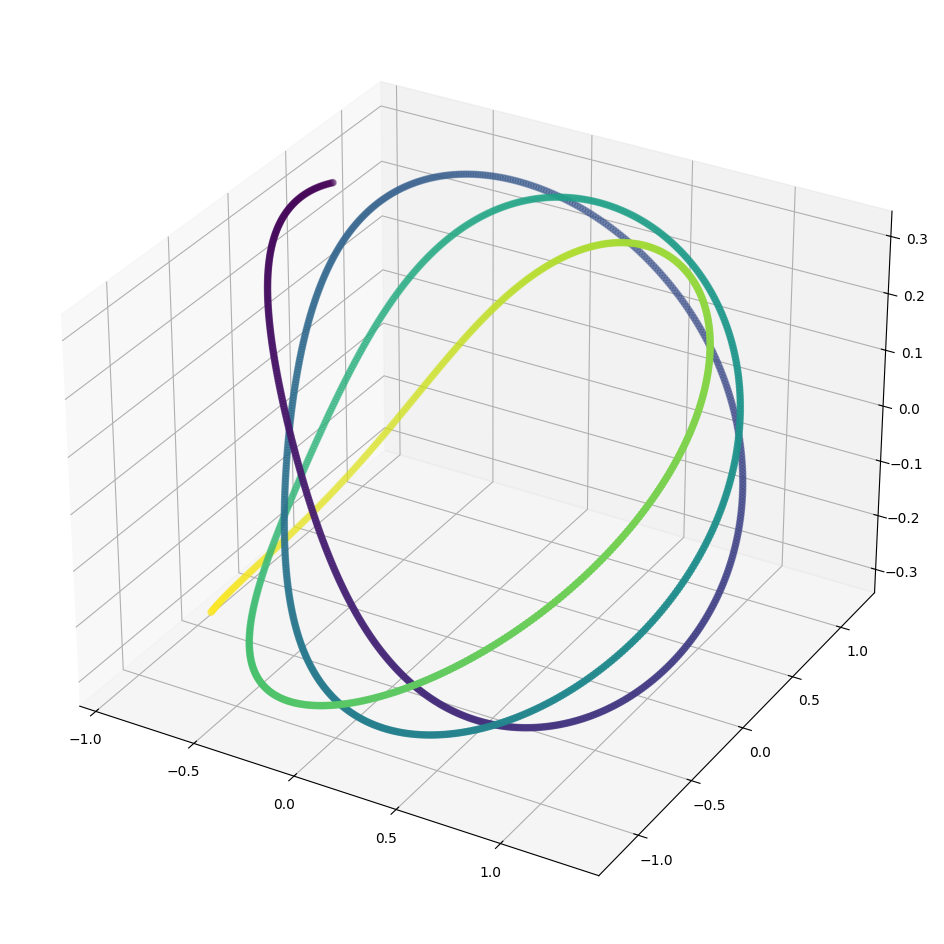

In [44]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c=y[:,0], cmap='viridis')
plt.show()

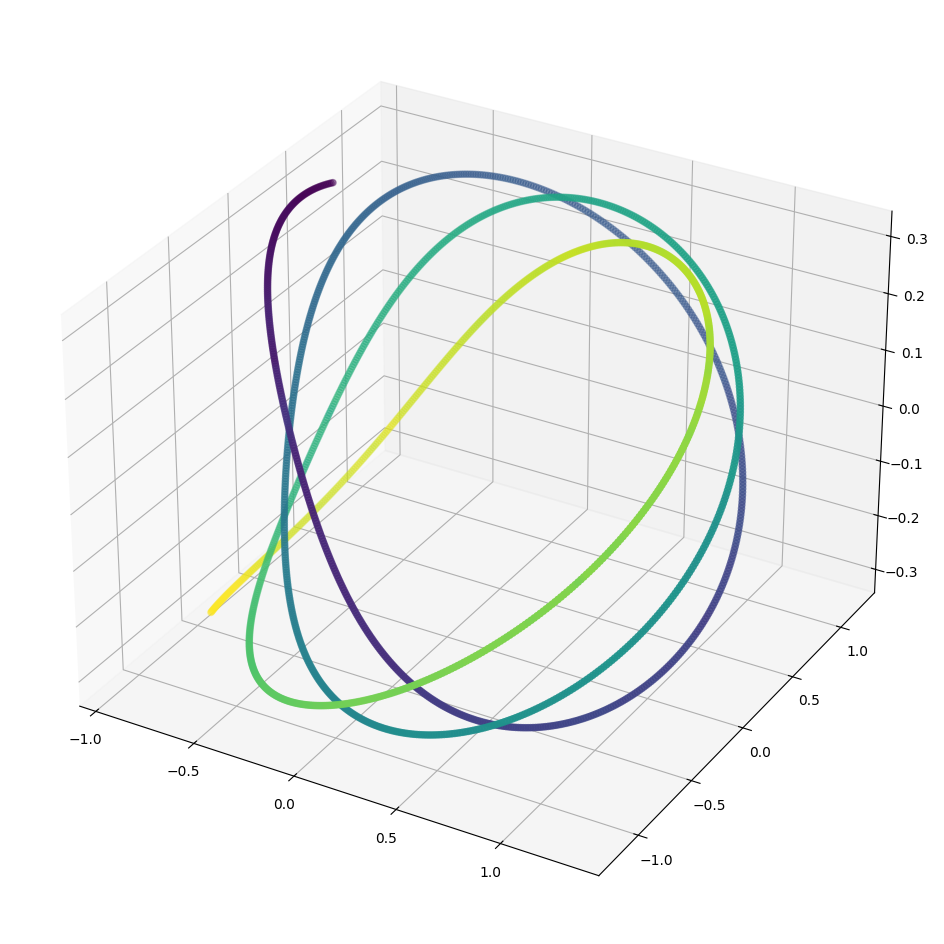

In [45]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c=yhat[:,0], cmap='viridis')
plt.show()

In [12]:
x = torch.arange(-3, 3, 0.01, device='cuda').reshape((-1, 1))
yhat = model({'x': x})
x = x.cpu().detach().numpy()
y = np.sin(10*x)
yhat = yhat.cpu().detach().numpy()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (600x1 and 3x512)

In [ ]:
plt.plot(x, y)
plt.plot(x, yhat)

In [ ]:
x = torch.arange(-1, 1, 0.01, device='cuda')
x = torch.meshgrid(x, x)
x = torch.stack([x[0], x[1]])#.flatten(start_dim=1, end_dim=2).T
y = f(x[0,:,:]) + f(x[1,:,:])

In [ ]:
model.to('cuda')

In [ ]:
yhat = model({'x': x.transpose(0,2)}).transpose(0,2)

In [ ]:
model({'x': torch.Tensor([[1, 0]]).to('cuda')})

In [ ]:
xnp = x.cpu().detach().numpy()
ynp = y.cpu().detach().numpy()
yhatnp = yhat.cpu().detach().numpy()

In [ ]:
ynp.shape

In [ ]:
plt.contourf(xnp[0], xnp[1], ynp)
plt.show()

In [ ]:
plt.contourf(xnp[0], xnp[1], yhatnp[0])
plt.show()

In [ ]:
yhatnp

In [ ]:
plt.scatter(y, yhat)
plt.show()

In [ ]:
np.corrcoef(y.flatten(), yhat.flatten())

In [ ]:
batch = next(iter(val))

In [ ]:
batch['x'].shape

In [ ]:
x = batch['x'].cpu().detach().numpy()
plt.scatter(x[:,0], x[:,1])